<a href="https://colab.research.google.com/github/Mahnazshamissa/Python/blob/main/bayes_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-optimize

     |████████████████████████████████| 102kB 2.4MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, plot_precision_recall_curve
from sklearn.model_selection import train_test_split

In [3]:
import skopt
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from skopt.space import Real, Integer, Categorical
import joblib
import gc

from skopt.utils import use_named_args
import itertools
from skopt import gp_minimize

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, plot_precision_recall_curve
from sklearn.utils import class_weight
from sklearn.model_selection import KFold

In [4]:
abo_path = '/content/WA_Fn-UseC_-Telco-Customer-Churn.csv'
p_df_raw = pd.read_csv(abo_path, sep=',', encoding="UTF-8")

In [5]:
p_df_raw.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [6]:
p_df_raw.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# **Transform the data: make every column into number and scale the values of each column**

In [7]:
df_y = p_df_raw['Churn']
df_y = pd.DataFrame(LabelEncoder().fit_transform(df_y))
df_y = df_y.reset_index(drop=True)

df_X_raw = p_df_raw.drop(['customerID', 'Churn'], axis=1)
#df_X_raw = p_df_raw_train.drop(['Name'], axis=1)

columns=df_X_raw.columns
for f in df_X_raw.columns:
    if df_X_raw[f].dtype == 'object':
        df_X_raw[f] = LabelEncoder().fit_transform(list(df_X_raw[f]))

In [32]:
p_df_raw.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [8]:
scaler = PowerTransformer()
scaled_df = scaler.fit_transform(df_X_raw)
df_X = pd.DataFrame(scaled_df, columns=columns)
df_X = df_X.reset_index(drop=True)

In [9]:
class_labels = np.unique(df_y)
class_weights = compute_class_weight('balanced', class_labels, df_y)
class_weights = dict(zip(class_labels, class_weights))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
class_weights

{0: 0.6806146115191342, 1: 1.8841626538255751}

In [11]:
df_X.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [12]:
df_X_sub, X_test, df_y_sub, y_test = train_test_split(df_X, df_y, test_size=0.33, random_state=42)

In [13]:
categorical_feature=['gender', 'SeniorCitizen', 'Partner',
                     #'PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity', 'DeviceProtection', 'TechSupport',
                     'StreamingTV', 'StreamingMovies','Contract', 'PaperlessBilling', 'PaymentMethod' ]

In [14]:
space  = [ Integer(3, 30, name='max_depth')
          ,Integer(6, 50, name='num_leaves')
          ,Integer(50, 200, name='min_child_samples')
          ,Real(1, 500,  name='scale_pos_weight')
          ,Real(0.6, 0.9, name='subsample')
          ,Real(0.6, 0.9, name='colsample_bytree')
          ,Real(0.0001, 1,  name='learning_rate', prior='log-uniform')
          ,Integer(2, 200, name='max_bin')
          #,Integer(100, 1000, name='num_iterations')
          ,Integer(20, 100, name='min_child_samples')
          #,Real(0.0001, 1,  name='lambda_l2', prior='log-uniform')          
          #,Real(0.0001, 1,  name='lambda_l1', prior='log-uniform')          
         ]

In [15]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

### for unbalanced classes
def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
    a,g = alpha, gamma
    y_true = dtrain.label
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    # (eval_name, eval_result, is_higher_better)
    return 'focal_loss', np.mean(loss), False

def focal_loss_lgb_f1_score(preds, lgbDataset):
    preds = sigmoid(preds)
    binary_preds = [int(p>0.5) for p in preds]
    y_true = lgbDataset.get_label()
    return 'f1', f1_score(y_true, binary_preds), True


focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha=0.25, gamma=1.)
focal_loss_eval = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha=0.25, gamma=1.)

In [29]:
def objective(values):
    
    params = {
              'max_depth': values[0]
              ,'num_leaves': values[1]
              ,'min_child_samples': values[2]
              ,'scale_pos_weight': values[3]
              ,'subsample': values[4]
              ,'colsample_bytree': values[5]
              ,'learning_rate': values[6]
              ,'max_bin': values[7]              
              #,'num_iterations': values[8]
              ,'min_child_samples': values[8]
              #,'lambda_l1': values[9]
              #,'lambda_l2': values[10]
              ,'metric':'auc'
              ,'nthread': 8
              ,'boosting_type': 'gbdt'
              ,'objective': 'binary'                            
              ,'min_child_weight': 0
              ,'min_split_gain': 0
              ,'subsample_freq': 1
              }

    #print('\nNext set of params.....',params)
            
        # Fit model on feature_set and calculate validation AUROC
    
    train_auc_list = []
    valid_auc_list = []
    early_stopping_rounds = 50
    num_boost_round       = 100
    final_score = 0

    
    # Fit model on feature_set and calculate validation AUROC    
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for train_index, test_index in cv.split(df_X_sub, df_y_sub):
        X_train, X_valid = df_X_sub.loc[df_X_sub.index[train_index]], df_X_sub.loc[df_X_sub.index[test_index]]
        y_train, y_valid = df_y_sub.loc[df_y_sub.index[train_index]], df_y_sub.loc[df_y_sub.index[test_index]]
        
        train_data = lgb.Dataset(data=X_train, label=y_train, 
                                 categorical_feature=categorical_feature,
                                 params={'verbose': -1}, 
                                 free_raw_data=False)
        
        valid_data = lgb.Dataset(X_valid, label=y_valid,
                                 categorical_feature=categorical_feature,
                                 params={'verbose': -1}, 
                                 free_raw_data=False)
        
        evals_results = {}
        model_lgb     = lgb.train(params,
                                  train_data,
                                  valid_sets=valid_data, 
                                  evals_result=evals_results, 
                                  num_boost_round=num_boost_round,
                                  #early_stopping_rounds=early_stopping_rounds,
                                  verbose_eval=False,
                                  #fobj=focal_loss, 
                                  feval=focal_loss_eval
                                 )        
        
        #print(evals_results)
        
        #train_auc = -roc_auc_score(y_train, model_lgb.predict(X_train))
        #valid_auc = -roc_auc_score(y_valid, model_lgb.predict(X_valid))
        
        train_preds = sigmoid(model_lgb.predict(X_train))
        train_binary_preds = [int(p>0.5) for p in train_preds]
        
        valid_preds = sigmoid(model_lgb.predict(X_valid))
        valid_binary_preds = [int(p>0.5) for p in valid_preds]
        
        train_auc = f1_score(y_train, train_binary_preds)
        valid_auc = f1_score(y_valid, valid_binary_preds)
        
        #print('\nAUROC.....', -train_auc,".....iter.....", model_lgb.current_iteration())
        
        train_auc_list.append(train_auc)
        valid_auc_list.append(valid_auc)

        
    train_valid_diff = np.abs(np.mean(train_auc_list) - np.mean(valid_auc_list))       
    
    ### this is a good criteria to control over-fitting
    if train_valid_diff > 0.10:
            final_score = 0.05
    else:
        final_score = np.mean(train_auc_list)
    
    #final_score = np.mean(train_auc_list)
    
    print('TRAIN.....', np.mean(train_auc_list))
    print('VALID.....', np.mean(valid_auc_list))
    print('final score ..... ', final_score)
    
    gc.collect()
    
    #return  np.mean(train_auc_list)
    return -final_score

In [31]:
res_gp = gp_minimize(objective, space, acq_func="LCB", n_calls=10, random_state=0, n_random_starts=10)
"Best score=%.4f" % res_gp.fun

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TRAIN..... 0.4165128048664084
VALID..... 0.41651270622606984
final score .....  0.4165128048664084


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TRAIN..... 0.4165128048664084
VALID..... 0.41651270622606984
final score .....  0.4165128048664084


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TRAIN..... 0.4165128048664084
VALID..... 0.41651270622606984
final score .....  0.4165128048664084


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TRAIN..... 0.4165128048664084
VALID..... 0.41651270622606984
final score .....  0.4165128048664084


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TRAIN..... 0.4165128048664084
VALID..... 0.41651270622606984
final score .....  0.4165128048664084


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TRAIN..... 0.4165128048664084
VALID..... 0.41651270622606984
final score .....  0.4165128048664084


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TRAIN..... 0.4165128048664084
VALID..... 0.41651270622606984
final score .....  0.4165128048664084


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TRAIN..... 0.416582731802484
VALID..... 0.4165826472475433
final score .....  0.416582731802484


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TRAIN..... 0.4165128048664084
VALID..... 0.41651270622606984
final score .....  0.4165128048664084


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TRAIN..... 0.4235209347915801
VALID..... 0.4203979246695287
final score .....  0.4235209347915801


'Best score=-0.4235'

In [18]:
res_gp.x

[28,
 16,
 135,
 432.6861780913872,
 0.7526906882001043,
 0.8750168862058383,
 0.4837605406319893,
 18,
 42]

In [19]:
params = {'max_depth': res_gp.x[0]
              ,'num_leaves': res_gp.x[1]
              ,'min_child_samples': res_gp.x[2]
              ,'scale_pos_weight': res_gp.x[3]
              ,'subsample': res_gp.x[4]
              ,'colsample_bytree': res_gp.x[5]
              ,'learning_rate': res_gp.x[6]
              ,'max_bin':  res_gp.x[7]
              #,'num_iterations': values[8]
              ,'min_child_samples': res_gp.x[8]
              #,'lambda_l1': values[9]
              #,'lambda_l2': values[10]
              ,'metric':'auc'
              ,'nthread': 8
              ,'boosting_type': 'gbdt'
              ,'objective': 'binary'                            
              ,'min_child_weight': 0
              ,'min_split_gain': 0
              ,'subsample_freq': 1
              }

In [20]:
model_lgb = lgb.LGBMClassifier(**params, class_weight = class_weights).fit(df_X_sub, df_y_sub)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
clf_train_pred = model_lgb.predict(df_X_sub)
clf_test_pred = model_lgb.predict(X_test)

In [22]:
auc_train = roc_auc_score(df_y_sub, clf_train_pred)
print('\nAUROC.....',auc_train)


AUROC..... 0.5188721463504735


In [23]:
auc_test = roc_auc_score(y_test, clf_test_pred)
print('\nTEST AUROC.....', auc_test)


TEST AUROC..... 0.5109813496278558


In [24]:
fpr, tpr, threshold = roc_curve(y_test, clf_test_pred)

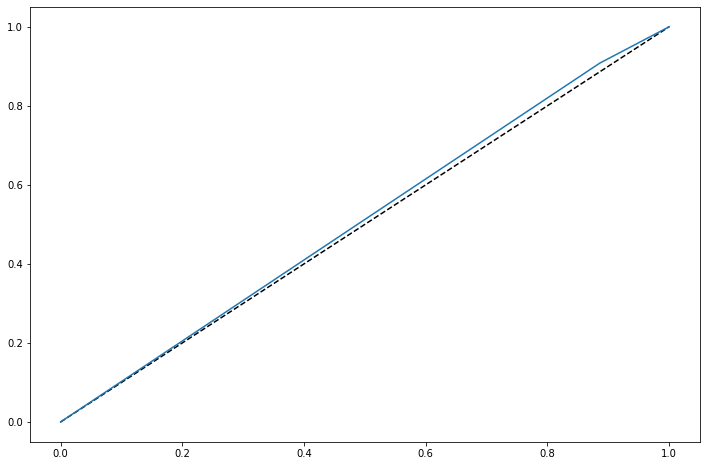

In [25]:
fig = plt.figure(figsize=(12,8)) 
ax = fig.add_subplot(1,1,1)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr);

In [26]:
print('Accuracy')
print(accuracy_score(y_test, clf_test_pred))
print('Confusion Matrix')
print(confusion_matrix(y_test, clf_test_pred))
print('Confusion Report')
print(classification_report(y_test, clf_test_pred))

Accuracy
0.3286021505376344
Confusion Matrix
[[ 194 1503]
 [  58  570]]
Confusion Report
              precision    recall  f1-score   support

           0       0.77      0.11      0.20      1697
           1       0.27      0.91      0.42       628

    accuracy                           0.33      2325
   macro avg       0.52      0.51      0.31      2325
weighted avg       0.64      0.33      0.26      2325



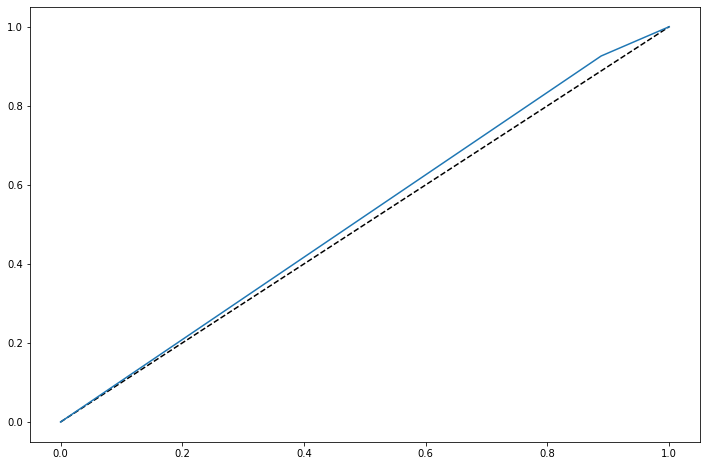

In [27]:
fpr, tpr, threshold = roc_curve(df_y_sub, clf_train_pred)
fig = plt.figure(figsize=(12,8)) 
ax = fig.add_subplot(1,1,1)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr);

# **training with CV**

In [28]:
eval_hist = lgb.cv(
    params = params, train_set = train_data,
    num_boost_round=100, 
    nfold=3,
    stratified=True,
    shuffle=True,
    #metrics='auc', 
    fobj=None, ### explore later in detail
    feval=None, ### explore later in detail
    init_model=None,
    feature_name='auto',
    #early_stopping_rounds=5,
    fpreproc=None,
    verbose_eval=20,
    show_stdv=True,
    seed=0,
    callbacks=None, ### explore later in detail
    eval_train_metric=False,
    return_cvbooster=False
)

NameError: ignored